<a href="https://colab.research.google.com/github/mohamedashraf111999/ML/blob/master/Multi_Classification_Model_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Required imports

import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

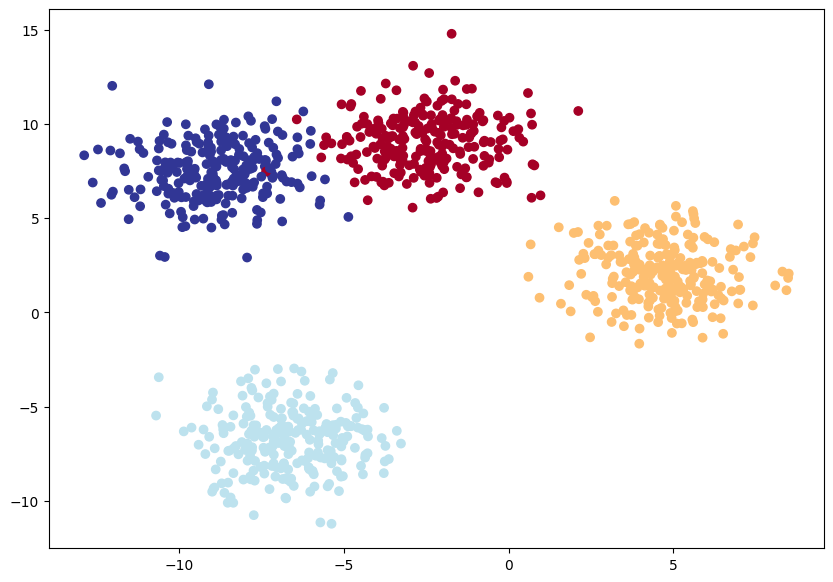

In [2]:
N_CLASSES = 4
N_FEATURES = 2
RAND_SEED = 42

# 1. importing the dataset
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=N_FEATURES,
                            centers= N_CLASSES,
                            cluster_std=1.5,
                            random_state=RAND_SEED)

# 2. Prep the dataset
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Spliting the dataset Train/test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RAND_SEED)

# 4. Visualize the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c= y_blob, cmap = plt.cm.RdYlBu)

In [3]:
# Device Agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# 5. Bulding Multi-Class classification model
class blobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
     super().__init__()

     #Layers Stack
     self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)

     );

  #Forward method
  def forward(self, x):
    return self.linear_layer_stack(x)


In [5]:
# Checking data shape
X_blob_train.shape, y_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), torch.Size([800]), tensor([1, 0, 2, 2, 0]))

In [6]:
#Checking Model Stracture
model = blobModel(input_features=2,
                  output_features=4,
                  hidden_units=8).to(device);


model

blobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [7]:
# 6. Intializing Loss Function, Optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model.parameters(), lr = 0.1)

In [8]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [9]:
#Checking Model output (Logits)
model(X_blob_test[:5].to(device))

tensor([[-0.2996,  0.1733, -0.4598, -1.9018],
        [-0.9951, -0.1599,  0.8027,  0.7719],
        [-0.2905,  0.4698,  0.0587,  3.3315],
        [-0.2056,  0.2892, -0.5007, -0.9850],
        [-0.7656, -0.1466,  0.2090, -1.8537]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [10]:
# Checking Predictions
model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test.to(device))
  y_preds = torch.argmax(torch.softmax(model(X_blob_test.to(device)), dim = 1), dim = 1)


###convrting logits to prediction probabilities
#y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
#print(y_pred_probs[:5])
#y_preds = torch.argmax(y_pred_probs, dim= 1)
print(y_preds[:5])

tensor([[-0.2996,  0.1733, -0.4598, -1.9018],
        [-0.9951, -0.1599,  0.8027,  0.7719],
        [-0.2905,  0.4698,  0.0587,  3.3315],
        [-0.2056,  0.2892, -0.5007, -0.9850],
        [-0.7656, -0.1466,  0.2090, -1.8537]], device='cuda:0')
tensor([1, 2, 3, 1, 2], device='cuda:0')


In [11]:
# 7. Training the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


for epoch in range(Epochs):

  #Training the Model
  model.train()

  y_logits = model(X_blob_train)
  y_pred = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)


  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  #Testing the model
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_blob_test)
    y_test_preds = torch.softmax(test_logits, dim = 1).argmax(dim= 1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test, y_pred = y_test_preds)


  # Printing what is happening
  if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f},  | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.73228,  | Test loss: 0.54190, Test acc: 88.00%
Epoch: 10 | Loss: 0.13693,  | Test loss: 0.12472, Test acc: 99.50%
Epoch: 20 | Loss: 0.07871,  | Test loss: 0.07077, Test acc: 99.50%
Epoch: 30 | Loss: 0.05866,  | Test loss: 0.05089, Test acc: 99.50%
Epoch: 40 | Loss: 0.04883,  | Test loss: 0.04084, Test acc: 99.50%
Epoch: 50 | Loss: 0.04308,  | Test loss: 0.03485, Test acc: 99.50%
Epoch: 60 | Loss: 0.03935,  | Test loss: 0.03090, Test acc: 99.50%
Epoch: 70 | Loss: 0.03676,  | Test loss: 0.02811, Test acc: 99.50%
Epoch: 80 | Loss: 0.03486,  | Test loss: 0.02604, Test acc: 99.50%
Epoch: 90 | Loss: 0.03342,  | Test loss: 0.02444, Test acc: 99.50%


In [12]:
### Download helper_functions if it is not dowloaded
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("Helper_funcation is exist")
else:
  print("Downloading Helper Functions")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

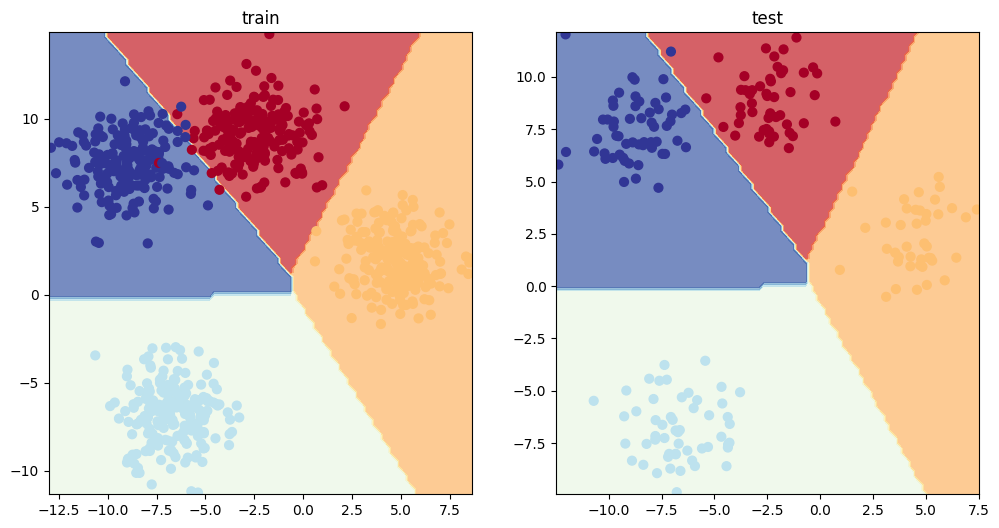

In [13]:
# 8. Visualize Results after training
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model, X_blob_test, y_blob_test)